In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import date

In [32]:
%%time 
## 20CR apcp
filelist=[]
for i in range(1981,2014,1):
    filelist.append(f'/Users/dongxiay/Documents/data/daily/apcp.{i}.nc')
ds1=xr.open_mfdataset(filelist,combine='by_coords')
ds=ds1['apcp'].loc[:,-45:0,100:160]

##Oliver MJO
df=pd.read_csv("/Users/dongxiay/Documents/data/MJO_ot12.csv")
df['time']=pd.to_datetime(df[['year','month','day']])
df=df.set_index('time').drop(columns=['year','month','day'])
df.loc[df['amplitude'].lt(1) ,'phase'] = 0

##NINO3.4
dateparser = lambda d: pd.datetime.strptime(d,'%Y%m%d')
df2=pd.read_csv('http://climexp.knmi.nl/data/inino34_daily.dat',
                skiprows=12,delim_whitespace=True,
                names=['time','enso'],
                parse_dates=['time'],
                date_parser=dateparser)
df2=df2.set_index(df2['time']).drop(columns='time')
df2.loc[df2['enso'].lt(-1) ,'watch'] = -1
df2.loc[df2['enso'].gt(1) ,'watch'] = 1
df2.loc[(df2['enso']>(-1)) & (df2['enso']<(1)),'watch']=0

##merge
dfmjo=df.loc[(df.index >= ds.time.min().values) & (df.index <= ds.time.max().values)][['amplitude','phase']]
dfenso=df2.loc[(df2.index >= ds.time.min().values) & (df2.index <= ds.time.max().values)]['watch']
data=xr.merge([ds,dfmjo.to_xarray(),dfenso.to_xarray()],join='inner').load()

data

<timed exec>:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


CPU times: user 14.9 s, sys: 1.16 s, total: 16.1 s
Wall time: 17.5 s


<xarray.Dataset>
Dimensions:    (time: 11810, lat: 46, lon: 61)
Coordinates:
  * time       (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2013-12-31
  * lat        (lat) float32 -45.0 -44.0 -43.0 -42.0 ... -3.0 -2.0 -1.0 0.0
  * lon        (lon) float32 100.0 101.0 102.0 103.0 ... 157.0 158.0 159.0 160.0
Data variables:
    apcp       (time, lat, lon) float32 0.3625 0.3125 0.2625 ... 1.025 0.875
    amplitude  (time) float64 1.773 1.754 1.641 1.486 ... 0.1155 0.2596 0.4505
    phase      (time) int64 2 2 2 2 2 2 2 2 2 2 3 3 ... 0 0 0 0 0 0 0 0 0 0 0 0
    watch      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/14)
    long_name:         daily mean 3-hourly accumulated total precipitation at...
    units:             kg/m^2
    GRIB_name:         APCP
    var_desc:          Precipitation amount
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3mo Dai...
    level_desc:        Surface
    ...                ...
    standard_name:     precipitation_amount
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ 0.    35.625]

In [18]:
datanino = data['apcp'].loc[data.watch== 1]
phasenino= data['phase'].loc[data.watch== 1]

In [25]:
def func(ds):
    return ds.count('time') / len(ds['time'])


THR=0.67
THR_threshold = datanino.where(datanino!=0).chunk(dict(time=-1)).quantile(THR, dim='time')

baseline = datanino.where(datanino >= THR_threshold).count('time') / len(datanino['time'])
baseline=baseline.compute()

result = datanino.where(datanino >= THR_threshold).groupby(phasenino).apply(func).compute()
ratio= result/baseline
ratio


<xarray.DataArray 'apcp' (phase: 9, lat: 46, lon: 61)>
array([[[1.21098294, 1.20546594, 1.18998324, ..., 0.98431782,
         0.93778241, 0.91844612],
        [1.19036332, 1.18684703, 1.17706407, ..., 0.97916983,
         0.95065328, 0.94240592],
        [1.17598344, 1.18089965, 1.18641787, ..., 1.02221425,
         1.05055086, 0.99168179],
        ...,
        [0.69232743, 0.76130991, 0.87594292, ..., 0.75614665,
         0.78188585, 0.7750272 ],
        [0.70057743, 0.80750988, 0.99227909, ..., 0.82989638,
         0.77329336, 0.75276345],
        [0.7664655 , 0.81617909, 1.00587322, ..., 0.87790692,
         0.85623173, 0.86522835]],

       [[1.03562412, 1.09038137, 1.11528752, ..., 1.22793037,
         1.16466525, 1.20938125],
        [1.1223617 , 1.20598972, 1.18315743, ..., 1.12299688,
         1.19969278, 1.27471489],
        [1.15511921, 1.17392348, 1.13873983, ..., 1.22457449,
         1.14284783, 1.19370928],
...
        [0.703494  , 0.52037225, 1.0384162 , ..., 1.30385405,
         1.20336082, 1.33345388],
        [0.59205618, 0.68146063, 0.74636165, ..., 1.33345388,
         1.36292127, 1.36292127],
        [0.62212675, 0.61794204, 0.4900465 , ..., 1.33345388,
         1.44071458, 1.42146227]],

       [[0.84978017, 0.81138184, 0.83243771, ..., 1.03174714,
         1.08793297, 1.05311289],
        [0.85731354, 0.84012767, 0.85565422, ..., 1.07191848,
         0.98769395, 0.89948644],
        [0.84978017, 0.88123857, 0.88535651, ..., 0.93305008,
         0.91862445, 0.92606966],
        ...,
        [1.22518618, 1.10451202, 1.11899555, ..., 1.27730085,
         1.32541442, 1.32541442],
        [1.06547938, 1.03422316, 1.03422316, ..., 1.12150451,
         1.15290451, 1.20376794],
        [0.82116316, 1.07052703, 1.12655633, ..., 0.98556457,
         0.95802369, 1.04649533]]])
Coordinates:
  * lat       (lat) float32 -45.0 -44.0 -43.0 -42.0 -41.0 ... -3.0 -2.0 -1.0 0.0
  * lon       (lon) float32 100.0 101.0 102.0 103.0 ... 157.0 158.0 159.0 160.0
    quantile  float64 0.67
  * phase     (phase) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0

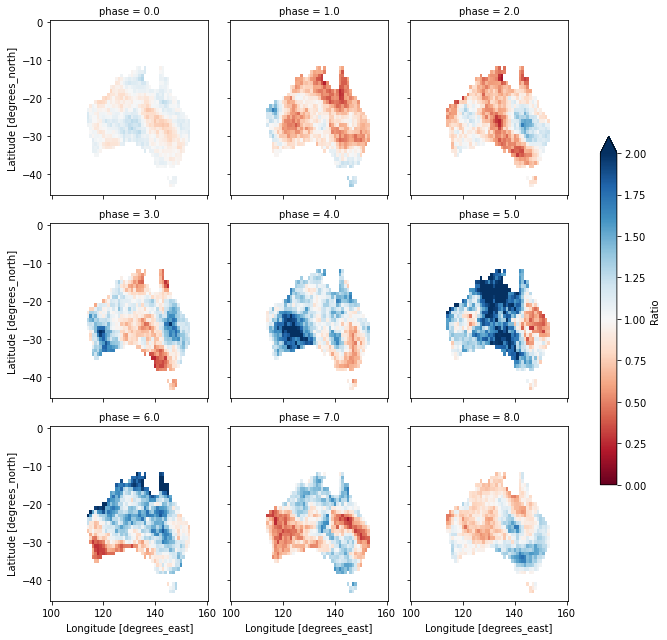

In [26]:
import regionmask
mask = regionmask.defined_regions.natural_earth.countries_110.mask(ratio)
AU_index = regionmask.defined_regions.natural_earth.countries_110.map_keys('AU')
ratio_AU = ratio.where(mask == AU_index)

cbar_kwargs = {'orientation':'vertical', 'shrink':0.6, 'label':'Ratio'}
ratio_AU.plot(col='phase', col_wrap=3, size=3,
             cmap='RdBu', vmin=0, vmax=2,
             cbar_kwargs=cbar_kwargs)

In [8]:
# import NCL colormap
! pip install cmaps
import cmaps

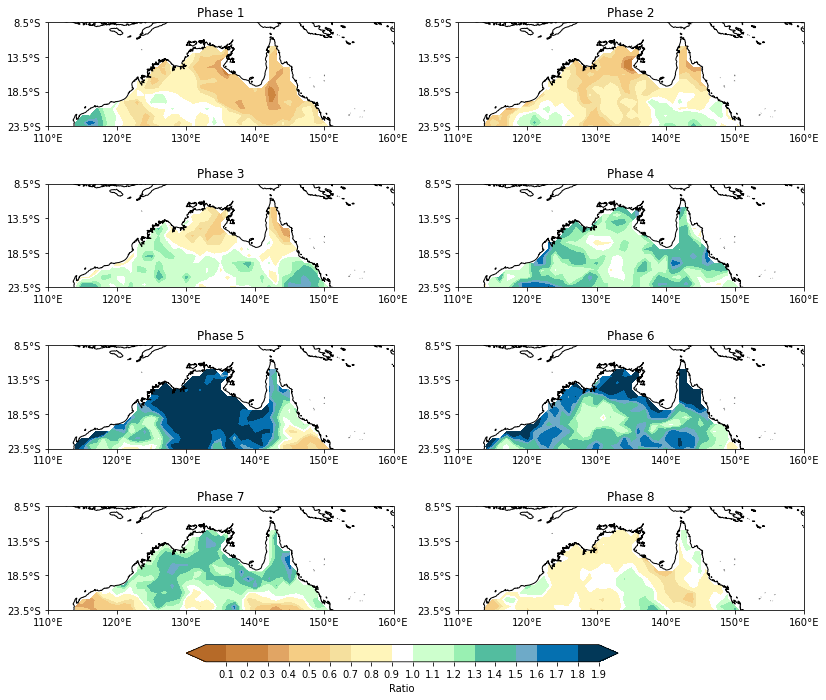

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 


leftlon, rightlon, lowerlat, upperlat = (110,160,-23.5,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

title=[]
for i in range(1,9,1):
    title.append(f'Phase {i}')
   
fig = plt.figure(figsize=(12,8))

for i in range(4):
    for j in range(2):
        ax = fig.add_axes([0.1+j*0.475, 1.5-i*0.28, 0.4, 0.3],projection = ccrs.PlateCarree())
#         ax.set_title('({})'.format(title[i,j]),loc='left',fontsize=14)
        ax.set_extent(img_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE) 
        ax.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lowerlat,upperlat+5,5), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.title.set_text(title[i*2+j])
        c = ax.contourf(THR_threshold['lon'],THR_threshold['lat'],ratio_AU[i*2+j+1,:,:],
                        levels=np.arange(0,2,0.1),
                        extend='both' ,
                        cmap=cmaps.precip_diff_12lev,
                        transform=ccrs.PlateCarree()) 
        
#colorbar, You would want to make sure the colorbar always sits in the same axes. 
# To this end, you may create a colorbar axes (cax) outside the loop
fig.colorbar(c, cax=fig.add_axes([0.26, 0.63, 0.5, 0.03 ]),
             orientation='horizontal',  
             label= 'Ratio', 
             ticks=np.arange(0.1,2.1,0.1),
             shrink=0.7)

In [34]:
datanina = data['apcp'].loc[data.watch== -1]
phasenina= data['phase'].loc[data.watch== -1]

In [35]:
def func(ds):
    return ds.count('time') / len(ds['time'])


THR=0.67
THR_threshold = datanina.where(datanina!=0).chunk(dict(time=-1)).quantile(THR, dim='time')

baseline = datanina.where(datanina >= THR_threshold).count('time') / len(datanina['time'])
baseline=baseline.compute()

result = datanina.where(datanina >= THR_threshold).groupby(phasenina).apply(func).compute()
ratio2= result/baseline
ratio2



<xarray.DataArray 'apcp' (phase: 9, lat: 46, lon: 61)>
array([[[0.92391247, 0.90604905, 0.89997776, ..., 1.11412182,
         1.12217512, 1.12091405],
        [0.91148534, 0.92069226, 0.91835789, ..., 1.12151686,
         1.09017432, 1.08702952],
        [0.92442732, 0.93774212, 0.93218595, ..., 1.0940287 ,
         1.06250492, 1.08303344],
        ...,
        [0.92923065, 0.97643566, 0.95592088, ..., 0.85560229,
         0.88750282, 0.88808235],
        [0.92474335, 0.93310979, 0.99430447, ..., 0.86584439,
         0.86928029, 0.8511263 ],
        [0.91105484, 0.93551004, 0.98055802, ..., 0.81608322,
         0.89072498, 0.884114  ]],

       [[1.38530466, 1.33187541, 1.2762606 , ..., 0.76007866,
         0.83794038, 0.94176413],
        [1.47728889, 1.45750842, 1.34255177, ..., 0.78762737,
         0.86832723, 0.83240333],
        [1.39373451, 1.37846365, 1.24426559, ..., 0.7501213 ,
         0.86832723, 0.82513343],
...
        [0.41110293, 0.3764916 , 0.65499223, ..., 1.02127915,
         1.07306318, 1.02208541],
        [0.44537729, 0.43751769, 0.8767545 , ..., 1.13393912,
         1.20168549, 1.21861063],
        [0.41192023, 0.6929628 , 0.74856255, ..., 1.25993236,
         1.19693574, 1.17817905]],

       [[0.94157426, 0.92847084, 0.97013052, ..., 1.06886062,
         1.03552291, 0.95353618],
        [0.96625   , 0.94347643, 0.96818637, ..., 0.98453421,
         0.9202381 , 0.88679332],
        [1.04530088, 1.02722051, 1.00448524, ..., 1.01969614,
         0.95563187, 0.94937227],
        ...,
        [1.18225033, 1.33144685, 1.51272016, ..., 1.43843042,
         1.33935644, 1.29091516],
        [1.38219395, 1.48410948, 1.23391454, ..., 1.20940382,
         1.24615575, 1.32851274],
        [1.50476309, 1.3685359 , 1.16605512, ..., 1.27305665,
         1.14575099, 1.05817933]]])
Coordinates:
  * lat       (lat) float32 -45.0 -44.0 -43.0 -42.0 -41.0 ... -3.0 -2.0 -1.0 0.0
  * lon       (lon) float32 100.0 101.0 102.0 103.0 ... 157.0 158.0 159.0 160.0
    quantile  float64 0.67
  * phase     (phase) int64 0 1 2 3 4 5 6 7 8

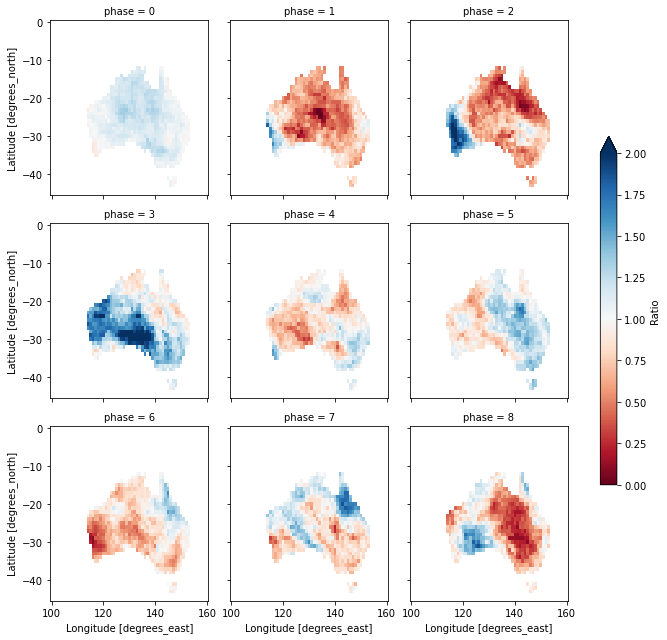

In [36]:
import regionmask
mask = regionmask.defined_regions.natural_earth.countries_110.mask(ratio2)
AU_index = regionmask.defined_regions.natural_earth.countries_110.map_keys('AU')
ratio2_AU = ratio2.where(mask == AU_index)

cbar_kwargs = {'orientation':'vertical', 'shrink':0.6, 'label':'Ratio'}
ratio2_AU.plot(col='phase', col_wrap=3, size=3,
             cmap='RdBu', vmin=0, vmax=2,
             cbar_kwargs=cbar_kwargs)

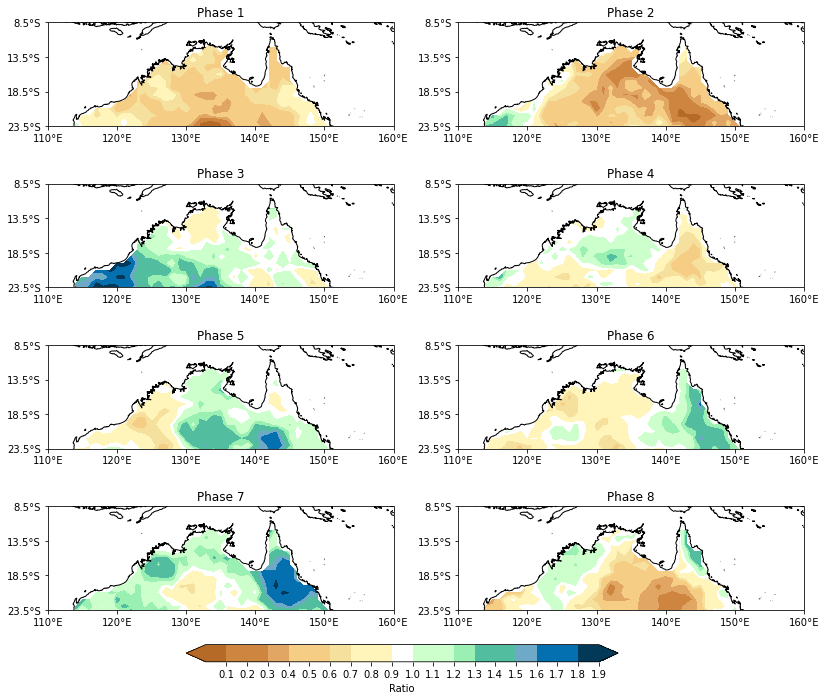

In [37]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 


leftlon, rightlon, lowerlat, upperlat = (110,160,-23.5,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

title=[]
for i in range(1,9,1):
    title.append(f'Phase {i}')
   
fig = plt.figure(figsize=(12,8))

for i in range(4):
    for j in range(2):
        ax = fig.add_axes([0.1+j*0.475, 1.5-i*0.28, 0.4, 0.3],projection = ccrs.PlateCarree())
#         ax.set_title('({})'.format(title[i,j]),loc='left',fontsize=14)
        ax.set_extent(img_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE) 
        ax.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lowerlat,upperlat+5,5), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.title.set_text(title[i*2+j])
        c = ax.contourf(THR_threshold['lon'],THR_threshold['lat'],ratio2_AU[i*2+j+1,:,:],
                        levels=np.arange(0,2,0.1),
                        extend='both' ,
                        cmap=cmaps.precip_diff_12lev,
                        transform=ccrs.PlateCarree()) 
        
#colorbar, You would want to make sure the colorbar always sits in the same axes. 
# To this end, you may create a colorbar axes (cax) outside the loop
fig.colorbar(c, cax=fig.add_axes([0.26, 0.63, 0.5, 0.03 ]),
             orientation='horizontal',  
             label= 'Ratio', 
             ticks=np.arange(0.1,2.1,0.1),
             shrink=0.7)